<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 55px"> 

# Project 3: Web APIs & NLP
## *03 - Modelling*

## **Background**

General Assembly is feeling the heat with more and more coding bootcamps popping up over the years. As an industry leader, the organization would like to keep its position and the marketing team is thus interested in streamlining and raising the effectiveness of its digital advertising efforts. They have as such, roped the data team in to provide some insights.

The starting point of most digital advertising strategies is finding the right keywords. While keywords such as 'bootcamps' and 'coding' are immediately apparent, being able to identify other less obvious ones are important here as well. Keywords that can help to differentiate similar groups of online personas into potential leads and less likely ones are appreciated.

Taking this into account and adding on the rise of social media (see [ourworldindata](https://ourworldindata.org/rise-of-social-media)) and its place in the advertising space, your team has decided to gather data from Reddit due to its uniqueness - it is a social media platform done in a forum style. Reddit contains a large amount of subreddits, which are essentially communities within the platform. According to Reddit themselves, 'there's a community for everybody'.

Each subreddit contains posts that are relevant to its topic. These features make Reddit a trove of social media-like text posts and therefore an ideal scraping candidate. 

## **Problem Statement**

This project aims to build a model with >90% accuracy that helps to identify between those who are looking for bootcamp style learning vs computer science majors/prospective students based on the words they use online.

### Contents
- [Dataset](#Load-and-Prep-Dataset)
- [Modelling](#Building-Models)
- [Evaluation](#Evaluation)
- [Conclusions and Reccomendations](#Conclusions-and-Reccomendations)

## Import Libraries

In [1]:
# Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier

# import warnings filter
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

## Load and Prep Dataset

In [2]:
df = pd.read_csv('datasets/merged_preprocessed.csv')

In [3]:
df['label'] = df['subreddit'].map({'codingbootcamp':1, 'csMajors':0})
df

,subreddit,title,created_utc,selftext,all_text,all_text_clean,label
0,codingbootcamp,Anyone from Toronto have advice on bootcamp ch...,1669244663,"Hello all, I'm a human biology graduate. I'm n...",Anyone from Toronto have advice on bootcamp ch...,toronto advice choice hello human biology grad...,1
1,codingbootcamp,IronHack vs Le Wagon,1669244075,Helloo!! I‘m looking for bootcamps and the bes...,IronHack vs Le Wagon Helloo!! I‘m looking for ...,ironhack v le wagon helloo looking best two op...,1
2,codingbootcamp,Is an associates degree enough?,1669243416,So I’ve been accepted into a local college tha...,Is an associates degree enough? So I’ve been a...,associate degree enough accepted local college...,1
3,codingbootcamp,Is freecodingbootcamp.org legit?,1669238234,I mean while it does sound too good to be true...,Is freecodingbootcamp.org legit? I mean while ...,freecodingbootcamporg legit mean doe sound tru...,1
4,codingbootcamp,"Artist to Coder, What are my options?",1669234613,"Hey guys, so I been holding onto the idea of b...","Artist to Coder, What are my options? Hey guys...",artist coder option hey guy holding onto idea ...,1
...,...,...,...,...,...,...,...
9054,csMajors,apple epm intern interview timeline?,1665788384,"for context, i'm a ghc '22 in-person attendee ...",apple epm intern interview timeline? for conte...,apple epm intern interview timeline context gh...,0
9055,csMajors,Lutron Electronics New Grad Final Interview,1665788244,Has anyone recently interviewed with Lutron El...,Lutron Electronics New Grad Final Interview Ha...,lutron electronics new grad final interview re...,0
9056,csMajors,Valkyrie Round 2,1665786853,Anyone done the Valkyrie Round 2 SWE Intern?\n...,Valkyrie Round 2 Anyone done the Valkyrie Roun...,valkyrie round done valkyrie round swe intern ...,0
9057,csMajors,HRT vs Citadel TC/Career/Reputation(Prestige) ...,1665785980,\n\n[View Poll](https://www.reddit.com/poll/y4...,HRT vs Citadel TC/Career/Reputation(Prestige) ...,hrt v citadel tc career reputation prestige pr...,0


In [4]:
df['all_text_clean'][df['all_text_clean'].isnull()]

513     NaN
687     NaN
774     NaN
777     NaN
1474    NaN
3762    NaN
4502    NaN
4522    NaN
Name: all_text_clean, dtype: object

In [5]:
# blank cells the result of stopword removal, delete these rows
df = df.dropna(how='any',
               subset=['all_text_clean'])

In [6]:
X = df['all_text_clean']
y = df['label']

# Check for proportion of each category
y.value_counts(normalize=True)

1    0.511767
0    0.488233
Name: label, dtype: float64

Classes are balanced so we go ahead and proceed with the train-test split before building the models.

In [7]:
# split data into train and test sets, ensure proportion of each category maintained
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Metrics Functions

In [8]:
def model_results(pipe, X_train, y_train, X_test, y_test):
    print('Train accuracy: ', pipe.score(X_train, y_train))
    print(f'Best model parameters: ', pipe.best_params_)
    print(f'Cross validation score: ', pipe.best_score_)
    
    # classification report on test
    print('\n Classification report:')
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('Label 1 is codingbootcamp')
    print('Label 0 is csMajors')

In [9]:
def subplot_matrix_roc(classifier, classifier_name):
    fig, ax= plt.subplots(1,2,figsize=(15,7))

    # plot confusion matrix on left
    metrics.plot_confusion_matrix(classifier, X_test, y_test,
                                  cmap='Blues',
                                  ax=ax[0]
                                 )
    ax[0].set_title(f'{classifier_name} Confusion Matrix', fontsize=14, weight='bold')

    # plot roc curve on right
    metrics.plot_roc_curve(classifier, X_test, y_test,
                           name=classifier_name,
                           ax=ax[1]
                          )
    ax[1].set_title(f'{classifier_name} ROC Curve', fontsize=14, weight='bold')
    #plotting baseline
    ax[1].plot(
        np.linspace(0, 1, 200),
        np.linspace(0, 1, 200),
        label='Baseline',
        linestyle='--',
        color='red')
    ax[1].legend(loc='best',fontsize=13,)

    plt.tight_layout()

## Building Models

A variety of models will be built using two different vectorization methods (namely CountVectorizer and TF-IDF) and 3 different classifiers (Naive Bayes Bernoulli, Naive Bayes Multinomial, and Logistic Regression. Hyperparameter tuning will be done using GridSearchCV on all models to maximize predictive accuracy.

Additionally, a model will also be built using Random Forest although it is unlikely to be the best performing.

Models will be fitted with the train dataset and subsequently evaluated on its performance against the test dataset. Primary metric of interest is accuracy due to this project's focus on correctly predicting if a user is a bootcamp seeker.

## CountVectorizer - Naive Bayes Bernoulli (Null Model)

In [10]:
# Number of features
# X_counts = count_vect.fit_transform(df['all_text_clean'])
# print(X_counts.shape)

In [11]:
# create pipeline for model
pipe_bern = Pipeline(steps=[
        ('cvec', CountVectorizer()),
        ('bern_nb', BernoulliNB())
        ])

cv_params = {
        'cvec__max_features': [6000], # [6000,8000,10000,None]
        'cvec__min_df': [2], # [1,2,3,4,5]
        'cvec__ngram_range': [(2,2)] # [(1,1), (1,2), (2,2)]
        } 

# Instantiate GridSearchCV.
pipe_bern_gs = GridSearchCV(pipe_bern, # What is the model we want to fit?
                            cv_params, # What is the dictionary of hyperparameters?
                            cv=5, # What number of folds in CV will we use?
                            verbose=1,
                            n_jobs=-1)

In [12]:
# fit model
bern_fit = pipe_bern_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [13]:
# get results
model_results(pipe_bern_gs, X_train, y_train, X_test, y_test)

Train accuracy:  0.9052740129640542
Best model parameters:  {'cvec__max_features': 6000, 'cvec__min_df': 2, 'cvec__ngram_range': (2, 2)}
Cross validation score:  0.8604868879306883

 Classification report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      1105
           1       0.81      0.93      0.87      1158

    accuracy                           0.86      2263
   macro avg       0.87      0.85      0.85      2263
weighted avg       0.86      0.86      0.86      2263

Label 1 is codingbootcamp
Label 0 is csMajors


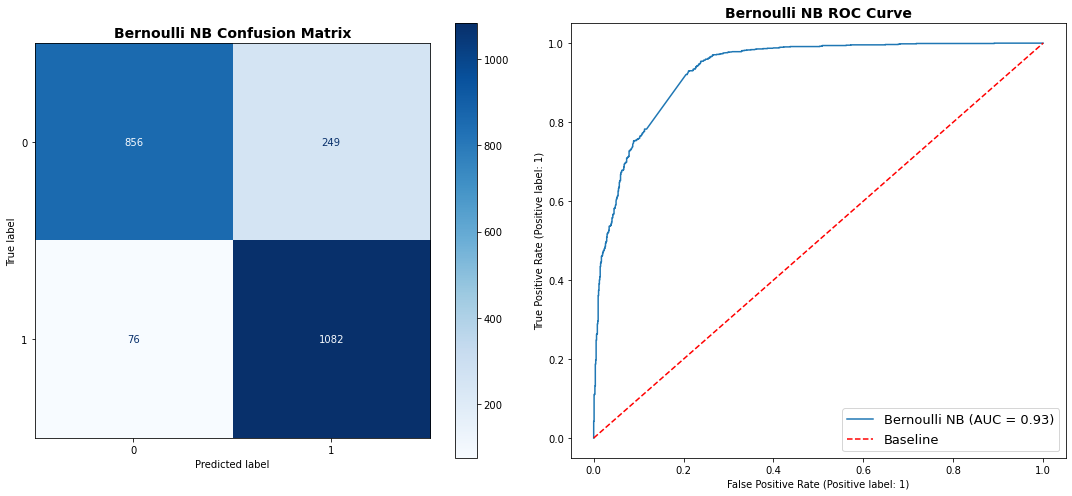

In [14]:
subplot_matrix_roc(pipe_bern_gs, 'Bernoulli NB')

## CountVectorizer - Naive Bayes Multinomial

In [15]:
# create pipeline for model
pipe_mnb = Pipeline(steps=[
        ('cvec', CountVectorizer()),
        ('mnb', MultinomialNB())
        ])

cv_params = {
        'cvec__max_features': [None], # [6000,8000,10000,None]
        'cvec__min_df': [1], # [1,2,3,4,5]
        'cvec__ngram_range': [(1,2)] # [(1,1), (1,2), (2,2)] 
        } 

# Instantiate GridSearchCV.
pipe_mnb_gs = GridSearchCV(pipe_mnb, # What is the model we want to fit?
                           cv_params, # What is the dictionary of hyperparameters?
                           cv=5, # What number of folds in CV will we use?
                           verbose=1,
                           n_jobs = -1)

In [16]:
mnb_fit = pipe_mnb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [17]:
model_results(pipe_mnb_gs, X_train, y_train, X_test, y_test)

Train accuracy:  0.985268120212139
Best model parameters:  {'cvec__max_features': None, 'cvec__min_df': 1, 'cvec__ngram_range': (1, 2)}
Cross validation score:  0.9108707047839003

 Classification report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1105
           1       0.89      0.95      0.92      1158

    accuracy                           0.91      2263
   macro avg       0.92      0.91      0.91      2263
weighted avg       0.92      0.91      0.91      2263

Label 1 is codingbootcamp
Label 0 is csMajors


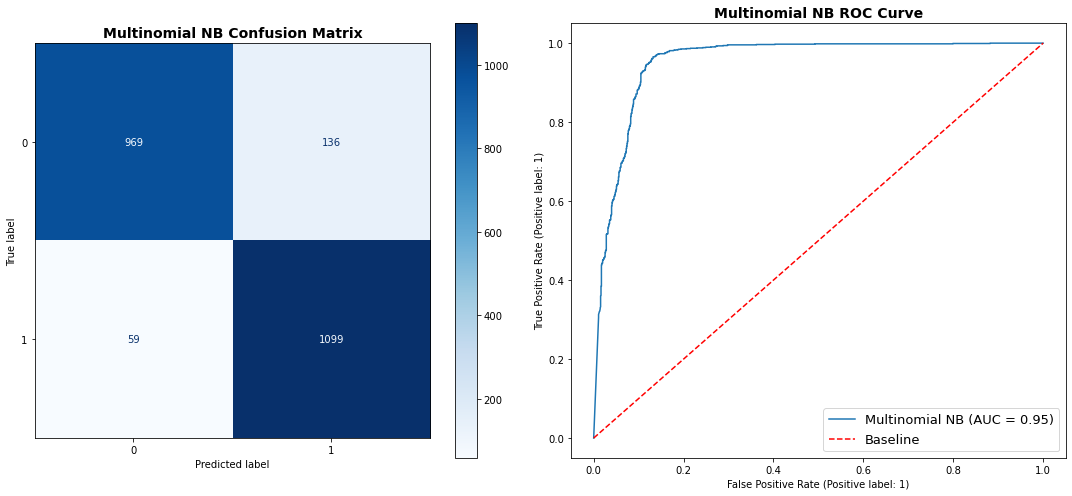

In [18]:
subplot_matrix_roc(pipe_mnb_gs, 'Multinomial NB')

## CountVectorizer - Logistic Regression

In [19]:
pipe_logit = Pipeline(steps=[
        ('cvec', CountVectorizer()),
        ('lr', LogisticRegression(max_iter=5000,solver='saga'))
        ])

# since there is already a l2 penalty in place, number of features not so relevant
cv_lr_params = {
        'cvec__max_features': [None], # [6000,8000,10000,None]
        'cvec__min_df': [3], # [1,2,3,4,5]
        'cvec__ngram_range': [(1,2)], # [(1,1), (1,2), (2,2)]
        'lr__C': [0.5] # [0.5,1.0] smaller C, stronger regularization
        } 

# Instantiate GridSearchCV.
pipe_logit_gs = GridSearchCV(pipe_logit, # What is the model we want to fit?
                             cv_lr_params, # What is the dictionary of hyperparameters?
                             cv=5, # What number of folds in CV will we use?
                             verbose=1,
                             n_jobs = -1)

In [20]:
logit_fit = pipe_logit_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [21]:
model_results(pipe_logit_gs, X_train, y_train, X_test, y_test)

Train accuracy:  0.9809958750736594
Best model parameters:  {'cvec__max_features': None, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'lr__C': 0.5}
Cross validation score:  0.9123446526655545

 Classification report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1105
           1       0.91      0.92      0.92      1158

    accuracy                           0.91      2263
   macro avg       0.91      0.91      0.91      2263
weighted avg       0.91      0.91      0.91      2263

Label 1 is codingbootcamp
Label 0 is csMajors


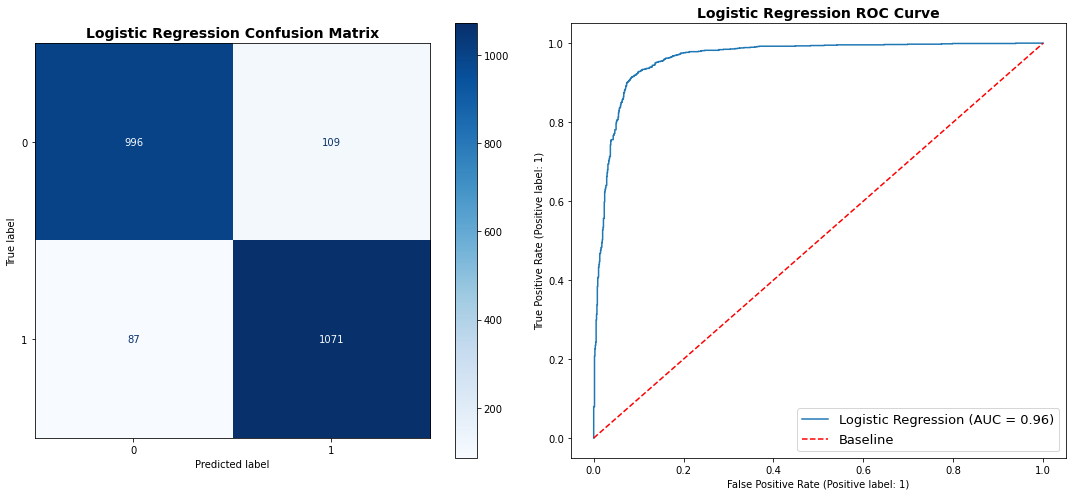

In [22]:
subplot_matrix_roc(pipe_logit_gs, 'Logistic Regression')

## TF-IDF - Naive Bayes Bernoulli 

In [23]:
pipe_tfidf_bern = Pipeline(steps=[
        ('tfidf', TfidfVectorizer()),
        ('bern', BernoulliNB())
        ])

tfidf_params = {
        'tfidf__max_features': [8000], # [6000,8000,10000,None]
        'tfidf__binary': [True], # [True, False]
        'tfidf__min_df': [1], # [1,2,3,4,5]
        'tfidf__ngram_range': [(2,2)] # [(1,1),(1,2),(2,2)]
        }

# Instantiate GridSearchCV.
pipe_tfidf_bern_gs = GridSearchCV(pipe_tfidf_bern, # What is the model we want to fit?
                                 tfidf_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1,
                                 n_jobs=-1)

In [24]:
tfidf_bern_fit = pipe_tfidf_bern_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [25]:
model_results(pipe_tfidf_bern_gs, X_train, y_train, X_test, y_test)

Train accuracy:  0.9172068355922216
Best model parameters:  {'tfidf__binary': True, 'tfidf__max_features': 8000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (2, 2)}
Cross validation score:  0.8519397049933634

 Classification report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85      1105
           1       0.83      0.93      0.88      1158

    accuracy                           0.87      2263
   macro avg       0.87      0.87      0.87      2263
weighted avg       0.87      0.87      0.87      2263

Label 1 is codingbootcamp
Label 0 is csMajors


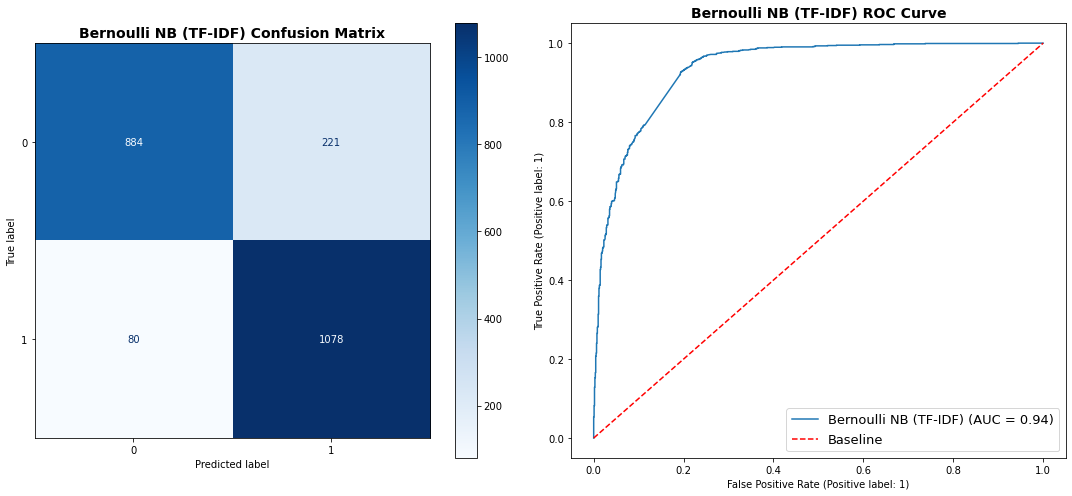

In [26]:
subplot_matrix_roc(pipe_tfidf_bern_gs, 'Bernoulli NB (TF-IDF)')

## TF-IDF - Naive Bayes Multinomial

In [27]:
pipe_tfidf_mnb = Pipeline(steps=[
        ('tfidf', TfidfVectorizer()),
        ('mnb', MultinomialNB())
        ])

tfidf_params = {
        'tfidf__max_features': [6000], # [6000,8000,10000,None]
        'tfidf__binary': [True], # [True,False]
        'tfidf__min_df': [2], # [1,2,3,4,5]
        'tfidf__ngram_range': [(1,1)] # [(1,1), (1,2), (2,2)]
        }

# Instantiate GridSearchCV.
pipe_tfidf_mnb_gs = GridSearchCV(pipe_tfidf_mnb, # What is the model we want to fit?
                                 tfidf_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1,
                                 n_jobs=-1)

In [28]:
tfidf_mnb_fit = pipe_tfidf_mnb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [29]:
model_results(pipe_tfidf_mnb_gs, X_train, y_train, X_test, y_test)

Train accuracy:  0.9273718326458457
Best model parameters:  {'tfidf__binary': True, 'tfidf__max_features': 6000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
Cross validation score:  0.9024722081434507

 Classification report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91      1105
           1       0.88      0.95      0.92      1158

    accuracy                           0.91      2263
   macro avg       0.91      0.91      0.91      2263
weighted avg       0.91      0.91      0.91      2263

Label 1 is codingbootcamp
Label 0 is csMajors


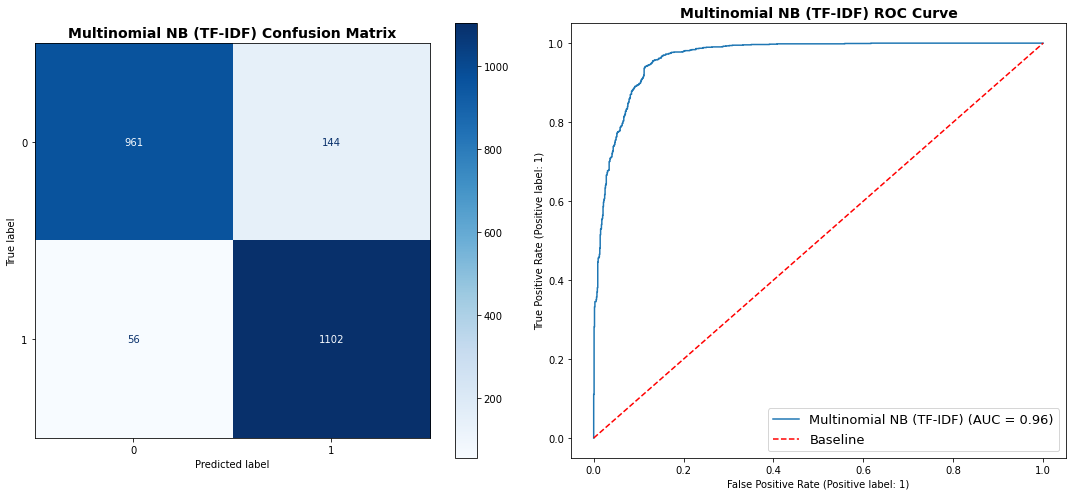

In [30]:
subplot_matrix_roc(pipe_tfidf_mnb_gs, 'Multinomial NB (TF-IDF)')

## TF-IDF - Logistic Regression

In [31]:
pipe_tfidf_logit = Pipeline(steps=[
        ('tfidf', TfidfVectorizer()),
        ('lr', LogisticRegression(max_iter=5000, solver='saga'))
        ])

tfidf_lr_params = {
        'tfidf__max_features': [6000], # [6000,8000,10000,None]
        'tfidf__binary': [True], # [True,False]
        'tfidf__min_df': [2], # [1,2,3,4,5]
        'tfidf__ngram_range': [(1,2)], # [(1,1),(1,2),(2,2)]
        'lr__C': [1.0] # [0.5,1.0]
        }

# Instantiate GridSearchCV.
pipe_tfidf_logit_gs = GridSearchCV(pipe_tfidf_logit, # What is the model we want to fit?
                                 tfidf_lr_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1,
                                 n_jobs=-1)

In [32]:
tfidf_logit_fit = pipe_tfidf_logit_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [33]:
model_results(pipe_tfidf_logit_gs, X_train, y_train, X_test, y_test)

Train accuracy:  0.9478491455509723
Best model parameters:  {'lr__C': 1.0, 'tfidf__binary': True, 'tfidf__max_features': 6000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Cross validation score:  0.9095451176086902

 Classification report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.91      1105
           1       0.90      0.95      0.92      1158

    accuracy                           0.92      2263
   macro avg       0.92      0.92      0.92      2263
weighted avg       0.92      0.92      0.92      2263

Label 1 is codingbootcamp
Label 0 is csMajors


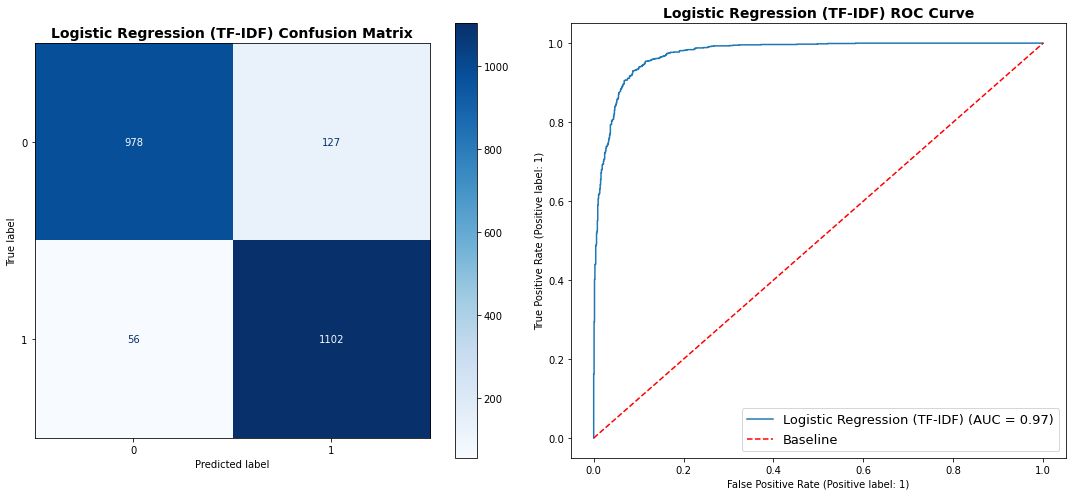

In [34]:
subplot_matrix_roc(pipe_tfidf_logit_gs, 'Logistic Regression (TF-IDF)')

## CountVectorizer - Random Forest

In [35]:
pipe_rf = Pipeline(steps=[
        ('cvec', CountVectorizer()),
        ('rf', RandomForestClassifier(random_state=42))
        ])

cv_rf_params = {
        'cvec__max_features': [6000], # [6000,8000,10000,None]
        'cvec__min_df': [2], # [1,2,3,4,5]
        'cvec__ngram_range': [(1,2)], # [(1,1), (1,2), (2,2)]
        'rf__n_estimators': [150], # [100,150,200]
        'rf__max_depth': [None] # [5,6,None]
        }

# Instantiate GridSearchCV.
pipe_rf_gs = GridSearchCV(pipe_rf, # What is the model we want to fit?
                                 cv_rf_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1,
                                 n_jobs=-1)

In [36]:
y_train_array = np.ravel(y_train)
rf_fit = pipe_rf_gs.fit(X_train, y_train_array)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [37]:
model_results(pipe_rf_gs, X_train, y_train_array, X_test, y_test)

Train accuracy:  0.9994107248084856
Best model parameters:  {'cvec__max_features': 6000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'rf__max_depth': None, 'rf__n_estimators': 150}
Cross validation score:  0.8956968883322499

 Classification report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1105
           1       0.88      0.92      0.90      1158

    accuracy                           0.90      2263
   macro avg       0.90      0.90      0.90      2263
weighted avg       0.90      0.90      0.90      2263

Label 1 is codingbootcamp
Label 0 is csMajors


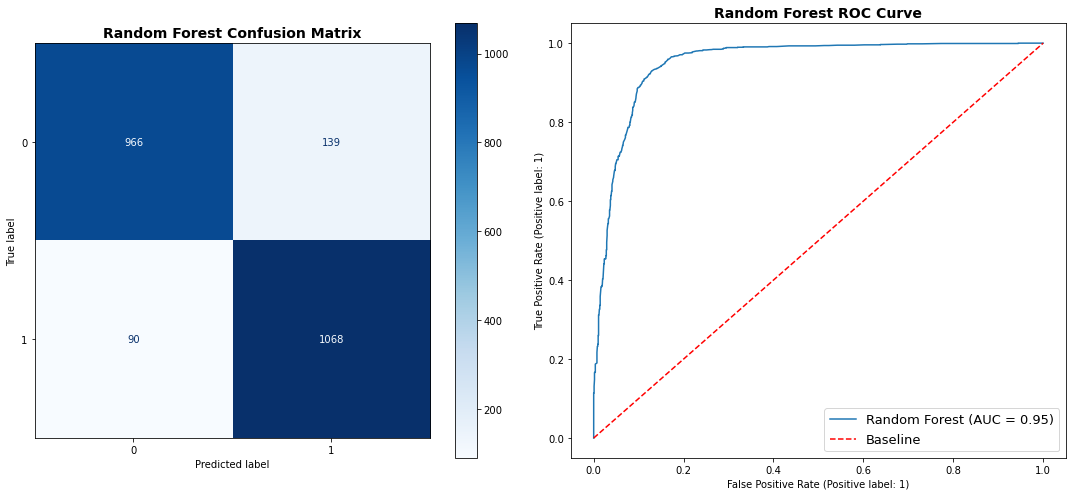

In [38]:
subplot_matrix_roc(pipe_rf_gs, 'Random Forest')

## Evaluation

### Train and Test Results
|Classifier|Vectorizer|N-gram Range|Train Score|Test Score|ROC AUC|
|:---|---:|---:|---:|---:|---:|
|Naive Bayes Bernoulli (Null)|CV|(2,2)|0.91|0.86|0.93|
|Naive Bayes Multinomial|CV|(1,2)|0.99|0.91|0.95|
|Logistic Regression|CV|(1,2)|0.98|0.91|0.96|
|Naive Bayes Bernoulli|TF-IDF|(2,2)|0.92|0.87|0.94|
|Naive Bayes Multinomial|TF-IDF|(1,1)|0.93|0.91|0.96|
|**Logistic Regression**|**TF-IDF**|**(1,2)**|0.95|**0.92**|**0.97**|
|Random Forest|CV|(1,2)|0.999|0.90|0.96|


### Selected Model
Logistic Regression using TF-IDF vectorizer and an n-gram range of (1,2) outperformed the rest of the built models on all considered metrics. It will thus be chosen as the production model. The high test accuracy score of 0.92 exceeds the 0.90 requirement set out in the problem statement, and beats the null model's accuracy.
To further supplement evaluation of the model, the high ROC AUC score (0.97) implies that the model is outstanding at distinguishing between the positive and negative classes.

This is in line with our problem statement as we are concerned mainly with correctly identifying potential coding boot camp registrants.

## Interpretation

In [39]:
def get_top_N_features(pipe, N=10):
    check_array = pipe[1].coef_[0, :]
    check_labels = pipe[0].get_feature_names_out()
    check_df = pd.DataFrame(check_array, index=check_labels)
    bottom_10 = check_df.sort_values(by=0, ascending=True).head(N)
    top_10 = check_df.sort_values(by=0, ascending=True).tail(N)
    plot_df = pd.concat([bottom_10, top_10])
    colors = ["r" if val < 0 else "b" for val in plot_df[0]]
    plt.figure(figsize=(6,8))
    plt.barh(y=plot_df.index, width=plot_df[0], color=colors)
    plt.title(f"Top {N} Features" + "\n" + f"(Positive: Contributes to r/codingbootcamp)", fontsize=20)
    return top_10

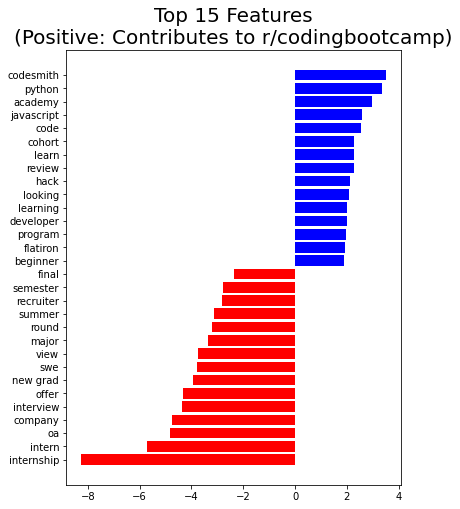

In [40]:
top_10 = get_top_N_features(pipe_tfidf_logit_gs.best_estimator_, 15)

Looking at the top 15 keywords that contribute more to the accurate prediction of a r/codingbootcamp post, we can reaffirm what was seen earlier during exploratory data analysis where the names of bootcamp providers and programming languages were salient. 

On the flip side, posts geared towards the themes of internship, recruitment and interview are much more likely to be from r/csMajors.

## Conclusions and Recommendations

### Conclusions
1. Logistic Regression using TF-IDF vectorizer and an n-gram range of (1,2) was the best performing model.
2. The production model is capable of predicting if a post belongs in to an accuracy of 92%, surpassing the 90% goal.
3. Top keywords relating to coding bootcamps are names of bootcamp providers and programming languages. The focus seems to be more on learning as well, as opposed to job-centric keywords related to the computer science major.

### Recommendations

1. Keyword findings from the exploratory data analysis and interpretation of the production model's coefficients should be used to guide advertising strategy and content.
2. The produtction model in its current form may be used to identify if a person is a worthwhile advertising target based on his/her online posts.
3. Names of competitors appear to be useful keywords to identify if searchers are potential bootcamp enrollers.

### Future Directions

The model in its current form is able to perform relatively well when it comes to predicting if a post should be classified as coming from someone interested in coding bootcamps or a computer science major, and by extension, able to identify said interest based on new posts. More subreddits could be added to increase its versatility in discerning other similar topics as well. 

At present, the model is only trained on data scraped from Reddit and while expected to generalize well across multiple social media platforms, it should be even more so if further trained on data from other sites. More formal texts could also be parsed through the model to identify keywords from a different perspective and for a different marketing angle.

Finally, the model could be deployed on a larger scale, continuously sorting through posts on popular platforms to find potential customers.